In [25]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt


from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

matplotlib.style.use('ggplot')

### Dados de Treino

In [26]:
df = pd.DataFrame.from_csv('../data/treino.csv')
df.head()

,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,Cálculo1,cra
matricula,,,,,,,,,,,,,
0cc3d63edf0b986cb87e345972857e15,8.6,10.0,9.0,9.1,8.6,8.4,8.3,8.8,8.2,7.9,9.4,8.7,8.477647
0d78246db769dc958ce19fc414050b2a,5.6,7.0,7.7,7.0,8.1,6.2,7.3,8.2,5.4,7.7,8.9,7.0,6.851724
0f5bb983df06b90337dc2c6301fef3f6,10.0,9.8,7.9,9.6,8.3,8.7,8.8,9.5,9.2,8.6,9.7,8.6,9.090588
1307a4421a67a497cea198e8ccfb97ee,6.1,8.3,6.8,8.2,7.1,8.0,6.3,8.9,7.0,8.5,9.0,7.8,7.283516
1432d50cf8519694ab992c414d90a130,8.8,9.3,5.0,8.5,5.1,5.0,5.8,7.1,5.4,8.7,8.2,5.2,7.205747


In [27]:
column_names = list(df)
column_names.pop()
column_names

['Vetorial',
 'LPT',
 'P1',
 'IC',
 'LP1',
 'Cálculo2',
 'Discreta',
 'P2',
 'Grafos',
 'Fís.Clássica',
 'LP2',
 'Cálculo1']

In [29]:
X_train = df.drop('cra', axis=1)
Y_train = df.cra

In [30]:
model_kernel_ridge = KernelRidge(alpha = [70]).fit(X_train, Y_train)

### Tratamento nos dados da Previsão

In [31]:
df_teste = pd.DataFrame.from_csv('../data/graduados_teste.csv')
df_teste.reset_index(inplace=True)
df_teste.head()

,ALU_NOVAMATRICULA,ALU_ANO_EVASA,ALU_PERIODO_EVASAO,MAT_TUR_DIS_DISCIPLINA,DISCIPLINA,CREDITOS,MAT_MEDIA_FINAL
0,3b3c1d5f7a47df614511c13e0c2a7f5a,2014,1,1109035,Álgebra Vetorial e Geometria Analítica,4,5.0
1,3b3c1d5f7a47df614511c13e0c2a7f5a,2014,1,1109103,Cálculo Diferencial e Integral I,4,3.8
2,3b3c1d5f7a47df614511c13e0c2a7f5a,2014,1,1411167,Programação I,4,5.3
3,3b3c1d5f7a47df614511c13e0c2a7f5a,2014,1,1411174,Introdução à Computação,4,5.4
4,3b3c1d5f7a47df614511c13e0c2a7f5a,2014,1,1307151,Leitura e Produção de Textos,4,7.8


### Calculando CRAS para avaliar a previsão

In [32]:
##Cálculo ponderado por créditos
df_teste_cra = df_teste
df_teste_cra['cra'] = df_teste_cra['MAT_MEDIA_FINAL']*df_teste_cra['CREDITOS']
df_teste_cra = df_teste_cra.groupby(['ALU_NOVAMATRICULA']).agg({'cra':'sum'})

df_teste_total_creditos = df_teste
df_teste_total_creditos = df_teste_total_creditos.groupby(['ALU_NOVAMATRICULA']).agg({'CREDITOS': 'sum'})
df_teste_cra['cra'] = df_teste_cra['cra'] / df_teste_total_creditos['CREDITOS']

df_teste_cra.head()

,cra
ALU_NOVAMATRICULA,
066a1b8f51616bc9f7cf392aec12df2c,6.790805
07e605cabb25fcd348569d15324433cc,7.230337
1298de387b2af5489ce432fe854ae0f7,5.738532
1471a43df7d59a219ad739462d791410,7.444828
25f50af45fa0065a73077d8d047a7cd1,7.429670


### Seleção de Features utilizadas no treinamento

In [33]:
df_teste = df_teste[['ALU_NOVAMATRICULA','DISCIPLINA', 'MAT_MEDIA_FINAL']]
df_teste.reset_index(inplace=True)
df_teste = (df_teste.pivot_table(index=['ALU_NOVAMATRICULA'], columns='DISCIPLINA',values='MAT_MEDIA_FINAL').reset_index())
df_teste.head()

DISCIPLINA,ALU_NOVAMATRICULA,Análise e Técnica de Algoritmos,Aval. de Desempenho de Sistemas Discretos,Banco de Dados I,Banco de Dados II,Compiladores,Cálculo Diferencial e Integral I,Cálculo Diferencial e Integral II,Direito e Cidadania,Engenharia de Software I,...,Projeto em Computação I,Projeto em Computação II,Redes de Computadores,Sistemas Operacionais,Sistemas de Informação I,Sistemas de Informação II,Teoria da Computação,Teoria dos Grafos,Álgebra Linear I,Álgebra Vetorial e Geometria Analítica
0,066a1b8f51616bc9f7cf392aec12df2c,7.3,8.6,6.60,7.0,7.7,7.0,5.0,9.7,7.0,...,6.6,7.6,5.4,6.2,7.0,5.0,7.6,7.1,5.7,7.0
1,07e605cabb25fcd348569d15324433cc,7.6,8.0,5.90,5.9,6.1,7.0,6.5,10.0,7.4,...,8.0,10.0,6.4,6.4,8.4,7.0,6.6,6.5,5.4,7.0
2,1298de387b2af5489ce432fe854ae0f7,8.0,8.6,5.75,5.0,6.2,5.6,5.0,7.0,8.7,...,8.9,7.7,5.0,8.1,7.9,5.0,6.2,5.6,NaN,5.0
3,1471a43df7d59a219ad739462d791410,7.1,8.9,6.70,7.2,5.8,7.0,6.3,8.3,8.3,...,8.7,9.0,7.5,7.0,7.9,7.0,7.6,5.4,7.5,6.8
4,25f50af45fa0065a73077d8d047a7cd1,7.4,9.1,6.20,8.8,7.8,7.8,7.3,10.0,9.2,...,8.7,9.1,7.4,7.0,7.9,7.0,7.4,7.5,8.2,7.4


In [34]:
df_teste = df_teste[['ALU_NOVAMATRICULA','Álgebra Vetorial e Geometria Analítica','Leitura e Produção de Textos', 
                     'Programação I','Introdução à Computação',
         'Laboratório de Programação I', 'Cálculo Diferencial e Integral II','Matemática Discreta','Programação II',
          'Teoria dos Grafos', 'Fundamentos de Física Clássica','Laboratório de Programação II',
          'Cálculo Diferencial e Integral I']]
df_teste = df_teste.set_index(['ALU_NOVAMATRICULA'])
df_teste.columns = column_names
df_teste = df_teste.fillna(0)
df_teste.head()

,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,Cálculo1
ALU_NOVAMATRICULA,,,,,,,,,,,,
066a1b8f51616bc9f7cf392aec12df2c,7.0,5.2,5.4,7.9,6.4,5.0,5.1,6.4,7.1,7.0,7.1,7.0
07e605cabb25fcd348569d15324433cc,7.0,7.2,7.9,8.7,7.7,6.5,7.9,8.7,6.5,7.2,9.0,7.0
1298de387b2af5489ce432fe854ae0f7,5.0,8.3,8.1,7.0,7.4,5.0,5.9,7.3,5.6,5.0,7.1,5.6
1471a43df7d59a219ad739462d791410,6.8,6.4,7.0,8.6,8.2,6.3,8.0,7.9,5.4,9.0,8.9,7.0
25f50af45fa0065a73077d8d047a7cd1,7.4,7.0,7.0,8.7,7.1,7.3,8.2,8.1,7.5,7.4,8.0,7.8


### Realizando Predição

In [35]:
pred = model_kernel_ridge.predict(df_teste)
resp = pd.DataFrame({'matricula': df_teste.index,'cra': pred})
resp.set_index(['matricula'], inplace=True)
resp
resp.to_csv('../data/graduatos_teste_previsao.csv')

### Avaliação

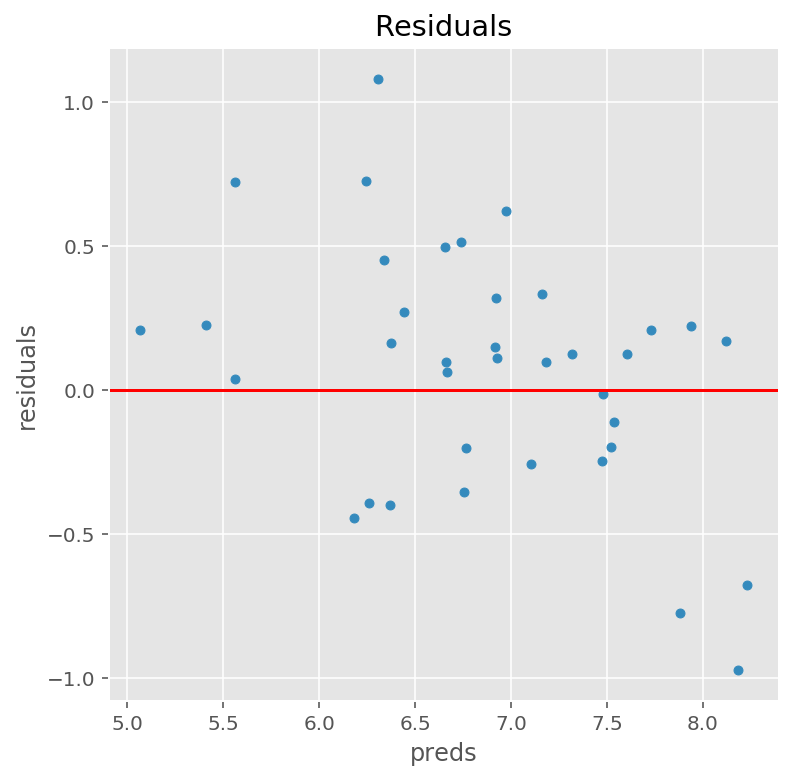

In [37]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":pred, "true":df_teste_cra['cra']})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

### RMSE

In [38]:
rmse = sqrt(mean_squared_error(preds.preds, preds.true))
rmse

0.4284060523068386